# Resolvr Case Study - Data Analytics

### Importing necessary libraries

In [30]:
%matplotlib inline
import pandas as pd
import pandas_profiling
import numpy as np
# visualization
import matplotlib.pyplot as plt
import seaborn as sns
# ML Suite
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.feature_selection import RFE
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, accuracy_score
# classification models
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier, LocalOutlierFactor
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBClassifier
# deep feature synthesis
import featuretools as ft

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
missing_values = ["n/a", "na", "--"]
df = pd.read_excel('D:/DS/reso.xlsx', na_values = missing_values)

### Summary Statistics

In [4]:
pandas_profiling.ProfileReport(df)

Number of variables,25
Number of observations,30000
Total Missing (%),0.1%
Total size in memory,5.7 MiB
Average record size in memory,200.0 B
Numeric,22
Categorical,0
Boolean,2
Date,0
Text (Unique),0
Rejected,1


In [5]:
df = df.rename(columns={"default payment next month": "FRAUD"})

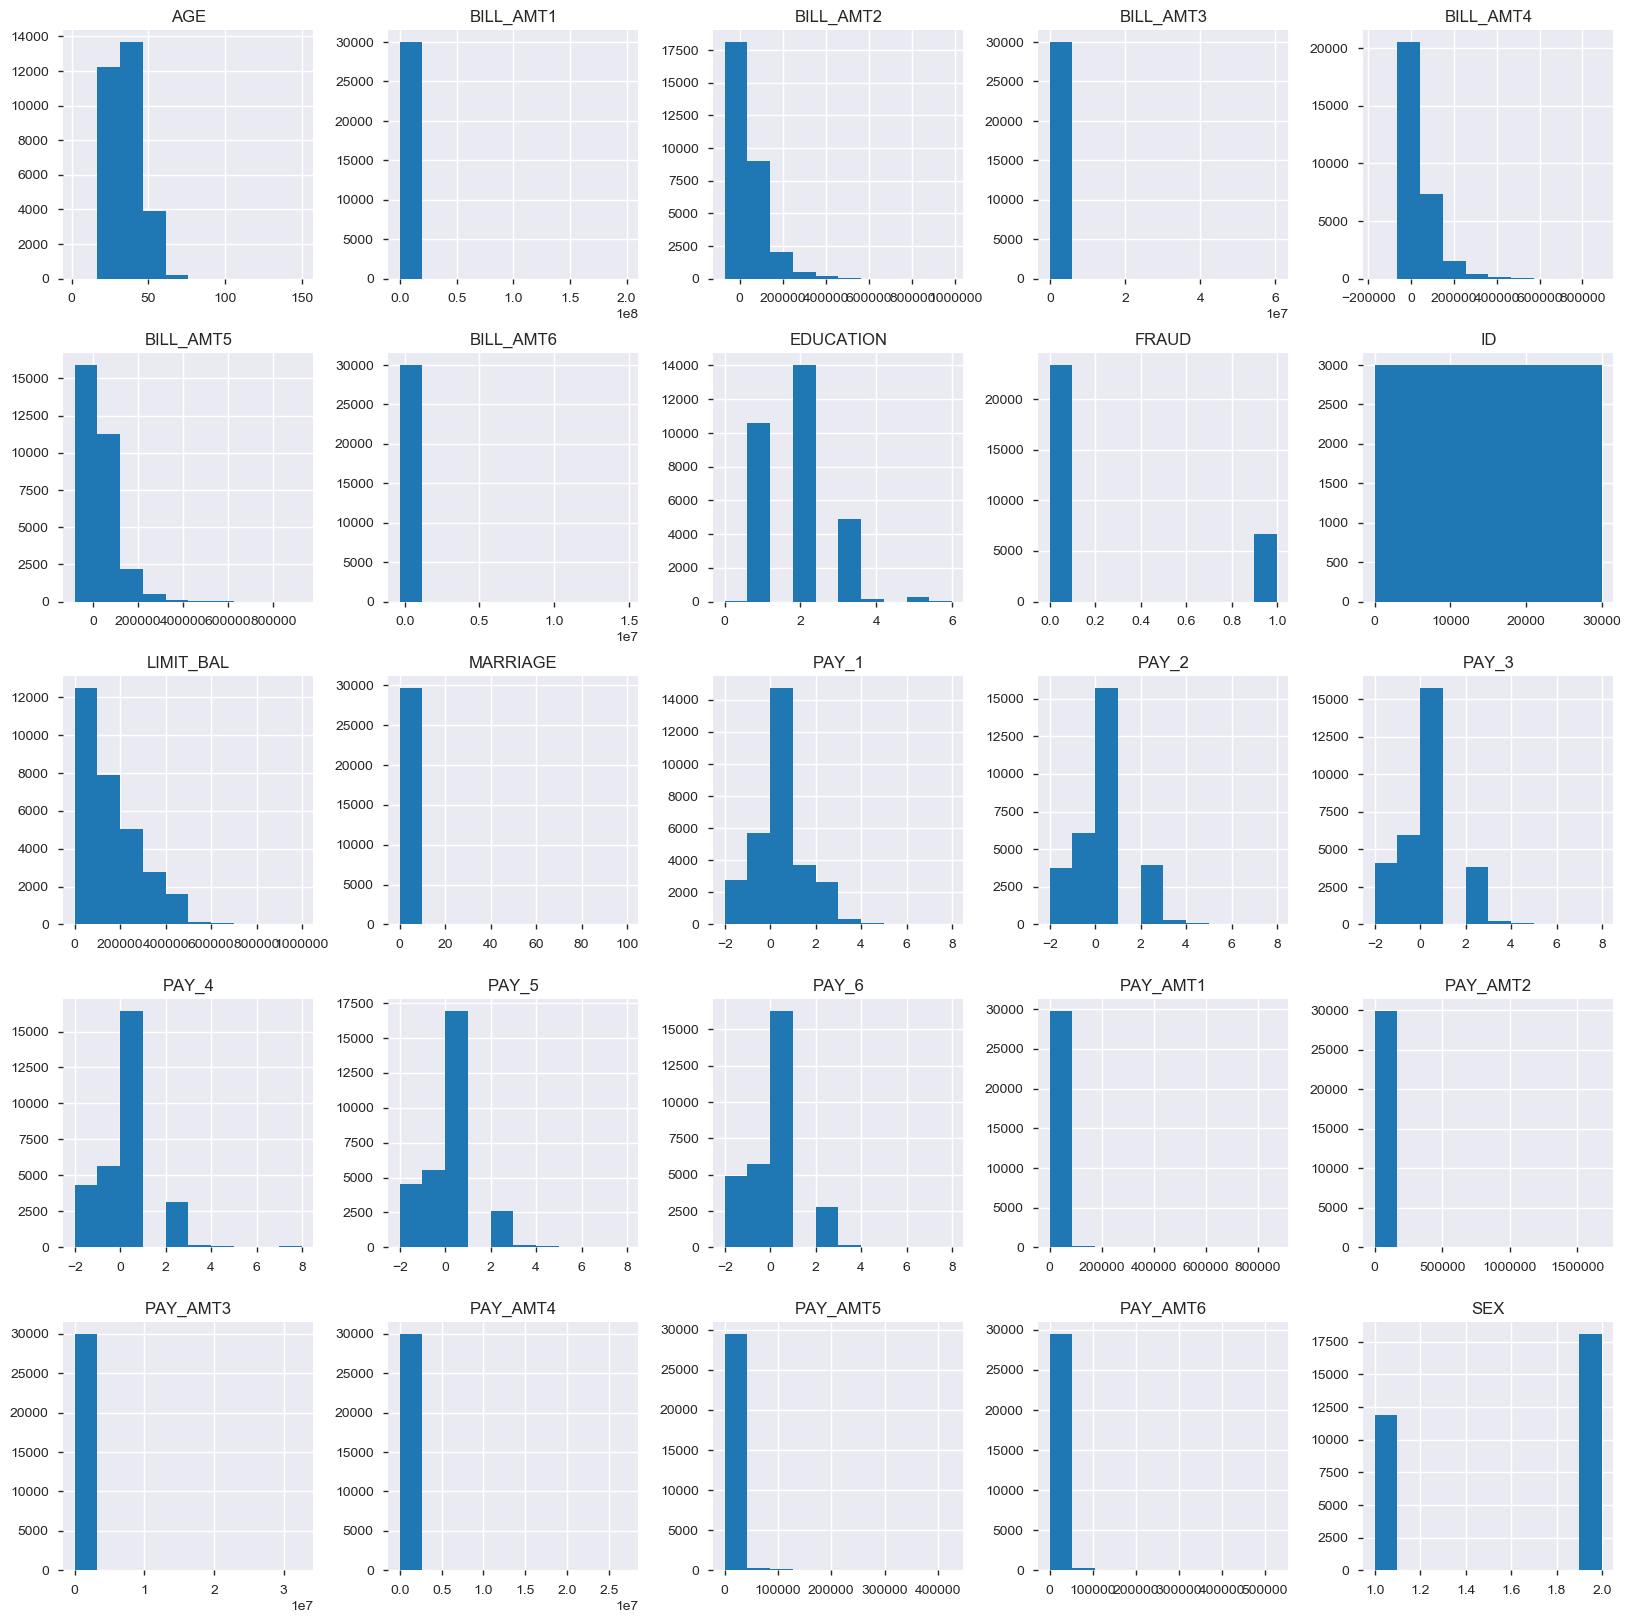

In [6]:
# Plot histogram for each feature vector
df.hist(figsize = (20, 20))
plt.show()

### Outlier Detection

In [7]:
# Determine number of fraud cases in dataset
Fraud = df[df['FRAUD'] == 1]
Valid = df[df['FRAUD'] == 0]

outlier_fraction = len(Fraud)/float(len(Valid))
print(outlier_fraction)

print('Fraud Cases: {}'.format(len(df[df['FRAUD'] == 1])))
print('Valid Transactions: {}'.format(len(df[df['FRAUD'] == 0])))

0.2840267077555213
Fraud Cases: 6636
Valid Transactions: 23364


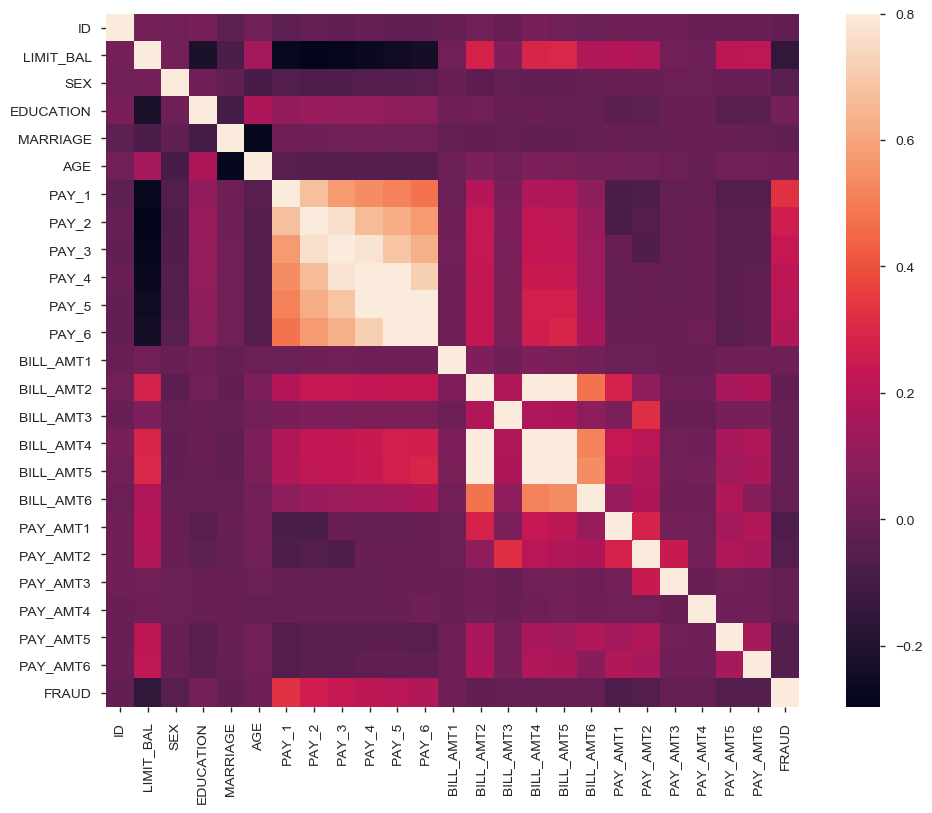

In [8]:
# Correlation matrix
corr_mat = df.corr()
fig = plt.figure(figsize = (12, 9))

sns.heatmap(corr_mat, vmax = .8, square = True)
plt.show()

In [9]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,FRAUD
0,1,20000.0,2,2,1.0,24,2.0,2.0,-1.0,-1.0,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2.0,26,-1.0,2.0,0.0,0.0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2.0,34,0.0,0.0,0.0,0.0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1.0,37,0.0,0.0,0.0,0.0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1.0,57,-1.0,0.0,-1.0,0.0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


### Checking for Missing Data

In [10]:
columns = df.columns.tolist()
for c in columns:
    print("{}:{}".format(c,df[c].isnull().any()))

ID:False
LIMIT_BAL:False
SEX:False
EDUCATION:False
MARRIAGE:True
AGE:False
PAY_1:True
PAY_2:True
PAY_3:True
PAY_4:True
PAY_5:True
PAY_6:True
BILL_AMT1:True
BILL_AMT2:True
BILL_AMT3:True
BILL_AMT4:True
BILL_AMT5:True
BILL_AMT6:True
PAY_AMT1:True
PAY_AMT2:True
PAY_AMT3:True
PAY_AMT4:True
PAY_AMT5:True
PAY_AMT6:True
FRAUD:False


In [11]:
len(df) - df.count()

ID             0
LIMIT_BAL      0
SEX            0
EDUCATION      0
MARRIAGE     313
AGE            0
PAY_1          1
PAY_2         32
PAY_3          1
PAY_4         34
PAY_5          1
PAY_6          1
BILL_AMT1      1
BILL_AMT2      1
BILL_AMT3      1
BILL_AMT4      1
BILL_AMT5      6
BILL_AMT6      1
PAY_AMT1       1
PAY_AMT2      19
PAY_AMT3       1
PAY_AMT4       1
PAY_AMT5       1
PAY_AMT6       1
FRAUD          0
dtype: int64

In [12]:
mc1 = ['MARRIAGE', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
mc2 = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']
mc3 = ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
missing_cols = mc1 + mc2 + mc3

## Mark 1

### The 'Marriage' feature vector can only be imputed using forward or backward fill since a manipulation of other values to arrive at a decimal value doesnt make sence for this particular feature vector.

In [13]:
df['MARRIAGE'].value_counts()

2.0      15796
1.0      13516
3.0        320
0.0         54
100.0        1
Name: MARRIAGE, dtype: int64

In [14]:
df['MARRIAGE'] = df['MARRIAGE'].replace([0, 100], np.nan)

In [15]:
df['MARRIAGE'].value_counts()

2.0    15796
1.0    13516
3.0      320
Name: MARRIAGE, dtype: int64

In [37]:
df['MARRIAGE'] = df['MARRIAGE'].fillna(method = 'ffill')

In [17]:
for m in missing_cols:
    df[m] = df[m].dropna()

In [18]:
len(df) - df.count()

ID           0
LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
AGE          0
PAY_1        0
PAY_2        0
PAY_3        0
PAY_4        0
PAY_5        0
PAY_6        0
BILL_AMT1    0
BILL_AMT2    0
BILL_AMT3    0
BILL_AMT4    0
BILL_AMT5    0
BILL_AMT6    0
PAY_AMT1     0
PAY_AMT2     0
PAY_AMT3     0
PAY_AMT4     0
PAY_AMT5     0
PAY_AMT6     0
FRAUD        0
dtype: int64

In [ ]:
df.sample(10)

In [35]:
scaler = StandardScaler()
scaled_df = scaler.fit_transform(df)
scaled_df = pd.DataFrame()

In [36]:
df.sample(10)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,FRAUD
0,1,20000.0,2,2,1.0,24,2.0,2.0,-1.0,-1.0,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2.0,26,-1.0,2.0,0.0,0.0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2.0,34,0.0,0.0,0.0,0.0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1.0,37,0.0,0.0,0.0,0.0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1.0,57,-1.0,0.0,-1.0,0.0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [19]:
# Get all the columns from the dataFrame
columns = df.columns.tolist()

# Filter the columns to remove data we do not want
columns = [c for c in columns if c not in ["FRAUD", "ID"]]

# Store the variable we'll be predicting on
target = "FRAUD"

X = df[columns]
y = df[target].copy()
y = pd.DataFrame(y)

# Print shapes
print(X.shape)
print(y.shape)

(30000, 23)
(30000, 1)


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [21]:
knn = KNeighborsClassifier(n_neighbors = 15)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
knn.score(X_test, y_test)

0.7721333333333333

In [22]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred_log = logreg.predict(X_test)
y_pred_prob = logreg.predict_proba(X_test)
logreg.score(X_test, y_test)

0.7829333333333334

In [23]:
dtree = DecisionTreeClassifier(max_depth = 10, random_state = 10, max_features = None, min_samples_leaf = 15)
dtree.fit(X_train, y_train)
y_pred_dt = dtree.predict(X_test)
dtree.score(X_test, y_test)

0.8069333333333333

In [24]:
rf = RandomForestClassifier(n_jobs = 10, random_state = 42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
rf.score(X_test, y_test)

0.8034666666666667

In [33]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
xgb.score(X_test, y_test)

0.8197333333333333

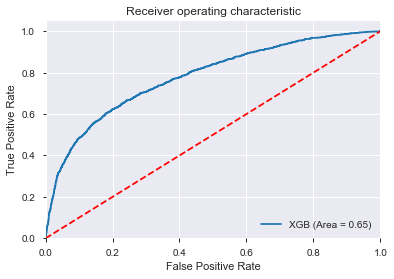

In [34]:
xgb_roc_auc = roc_auc_score(y_test, y_pred_xgb)
fpr, tpr, thresholds = roc_curve(y_test, xgb.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='XGB (Area = %0.2f)' % xgb_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [32]:
models = []

models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
#models.append(('SVM', SVC()))
models.append(('XGB', XGBClassifier()))
models.append(('RF', RandomForestClassifier()))

#testing models

results = []
names = []

for name, model in models:
    kfold = KFold(n_splits=10, random_state=42)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='roc_auc')
    results.append(cv_results)
    names.append(name)
    msg = '%s: %f (%f)' % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.642408 (0.016104)
LDA: 0.716393 (0.015158)
KNN: 0.606298 (0.009300)
CART: 0.610018 (0.011141)
XGB: 0.780800 (0.011000)
RF: 0.736170 (0.007197)


### Hyperparameter Optimization for Random Forest Classifier

n_estimators = [int(x) for x in np.linspace(start = 1, stop = 20, num = 10)]
max_depth = [int(x) for x in np.linspace(1, 50, num = 10)]
max_depth.append(None)
max_features = ['auto', 'sqrt']

param_grid = {
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'max_features': max_features,
}

estimator = RandomForestClassifier(random_state = 69)
cv_test = KFold(n_splits=5)
gscv = GridSearchCV(estimator, param_grid, n_jobs = -1, 
                        scoring = 'roc_auc', cv = cv_test, 
                        verbose = 2)

gscv.fit(X_train, y_train)

gscv.best_params_

best_model = gscv.best_estimator_

best_model.score(X_test,y_test)

rf2_pred = best_model.predict(X_test)
rf2_prob = best_model.predict_proba(X_test)[:, 1]
rf2_roc_auc = roc_auc_score(y_test, rf2_pred)
fpr, tpr, thresholds = roc_curve(y_test, rf2_prob)
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (Model Tuned) (area = %0.2f)' % rf2_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.04, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()